# AIN429: Data Mining Lab - Fall 2024
## **Assignment 3**  

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import combinations

# Part 1: Dataset Import, Preprocessing, and Analysis


- **Dataset**:
  - Loaded a dataset containing transaction data with **`83014`** transactions and **`2415`** unique items.
- **Preprocessing**:
  - Removed infrequent items appearing less than **2** times.
  - There were not any missing data.
  - Transformed the data into a list of transactions suitable for mining algorithms.

In [5]:
# Load dataset
file_path = 'transaction_data.csv'
df = pd.read_csv(file_path)

In [6]:
# Display basic information
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92250 entries, 0 to 92249
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Product                                92250 non-null  object
 1   Product Category (Enhanced Ecommerce)  92250 non-null  object
 2   Transaction ID                         92250 non-null  object
 3   Unique Purchases                       92250 non-null  int64 
 4   Product Revenue                        92250 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [7]:
print("\nDataset Preview:")
df.head()


Dataset Preview:


,Product,Product Category (Enhanced Ecommerce),Transaction ID,Unique Purchases,Product Revenue
0,3.7V 3400mah LIION 12.6WH,Battery/Consumer Rechargeable,EC0043605902,47,"$1,597.53"
1,3V PHOTO LITHIUM,Battery/Primary Other,EC0043507670,47,"$1,246.44"
2,12V 11.2AH 225CCA AGM 12/0,Battery/Powersports,EC0043504182,41,"$4,714.59"
3,12V 12AH 165CCA FLOODED 6/0,Battery/Powersports,EC0043503186,39,"$2,456.61"
4,12V 12AH 210CCA AGM 12/0,Battery/Powersports,EC0043406547,34,"$3,570.00"


### 1. Basic Dataset Information

In [9]:
# Number of transactions
num_transactions = df['Transaction ID'].nunique()
print(f"Number of transactions: {num_transactions}")

# Number of unique items
unique_items = df['Product'].nunique()
print(f"Number of unique items: {unique_items}")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Number of transactions: 83014
Number of unique items: 2415
Missing values in each column:
Product                                  0
Product Category (Enhanced Ecommerce)    0
Transaction ID                           0
Unique Purchases                         0
Product Revenue                          0
dtype: int64


### 2. Key Statistics

In [11]:
# Average number of items per transaction
items_per_transaction = df.groupby('Transaction ID')['Product'].count()
avg_items = items_per_transaction.mean()
print(f"Average number of items per transaction: {avg_items:.2f}")

# Frequency of items
item_frequency = df['Product'].value_counts()
print("Top 10 most frequent items:")
print(item_frequency.head(10))


Average number of items per transaction: 1.11
Top 10 most frequent items:
Product
12V U1 L&amp;G 6                  2425
6V GC2 ULTRA GOLF 12              1684
AGM 12V 7AH .187 FASTON           1642
12V 18AH 310CCA AGM 12/0          1204
12V 31DT DURACELL ULTRA AGM 30    1118
AGM 12V 5AH .187 FASTON           1077
DC 12V 35AH J TERM                1005
12V 17.5AH 310 CCA                 996
1.5V IND AA ALK BULK               979
1.5V ALKAL                         977
Name: count, dtype: int64


- The average number of items per transaction is 1.11, indicating that most customers purchase only one item per transaction, with occasional additional items. This suggests a buying pattern focused on single-item purchases rather than bulk or multiple-item orders.

- The top 10 most frequent items are predominantly various types of batteries, particularly 12V and 6V models, as well as bulk packs of 1.5V industrial alkaline batteries. This highlights a high demand for specific battery products, possibly reflecting the needs of customers in industries or activities that rely heavily on these power sources. The inclusion of both specialized batteries and common sizes like AA suggests a diverse customer base with varying requirements, from industrial applications to everyday use.

### 3. Clean and Transform Dataset for Frequent Pattern Mining

In [14]:
# Define minimum item frequency threshold
min_item_frequency = 2

# Count the frequency of each item
item_counts = df['Product'].value_counts()

# Identify frequent items
frequent_items = item_counts[item_counts >= min_item_frequency].index

# Remove infrequent items from the dataset
df = df[df['Product'].isin(frequent_items)].reset_index(drop=True)


### 4 Remove Infrequent Items and Handle Missing Data

In [16]:
# Group products by Transaction ID
transactions = df.groupby('Transaction ID')['Product'].apply(list)

# Ensure transactions are lists of frequent items
transactions = transactions.apply(lambda x: [item for item in x if item in frequent_items])

# Remove transactions that may have become empty after removing infrequent items
transactions = transactions[transactions.apply(len) > 0]


## 5. Visualizations

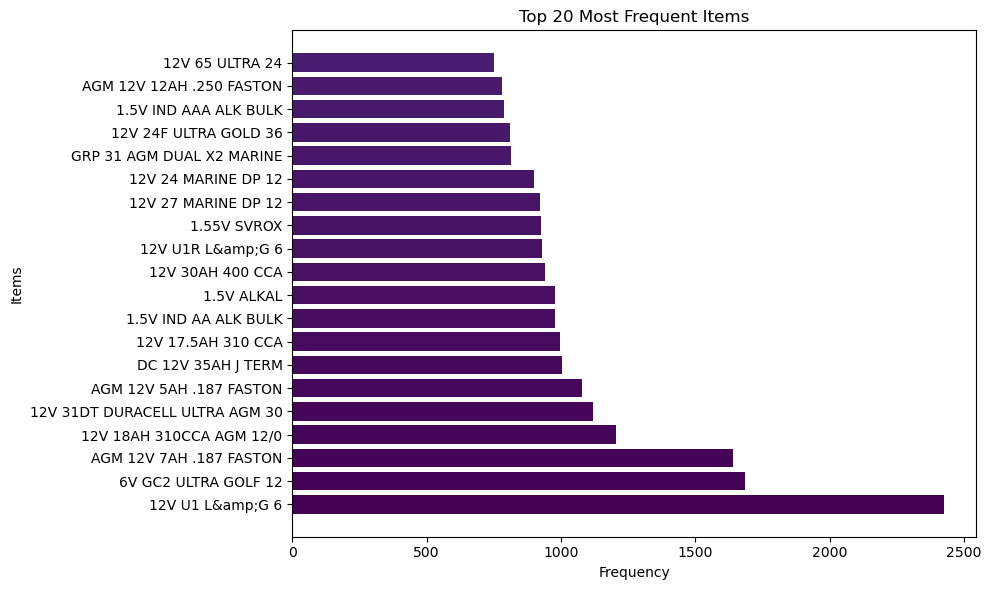

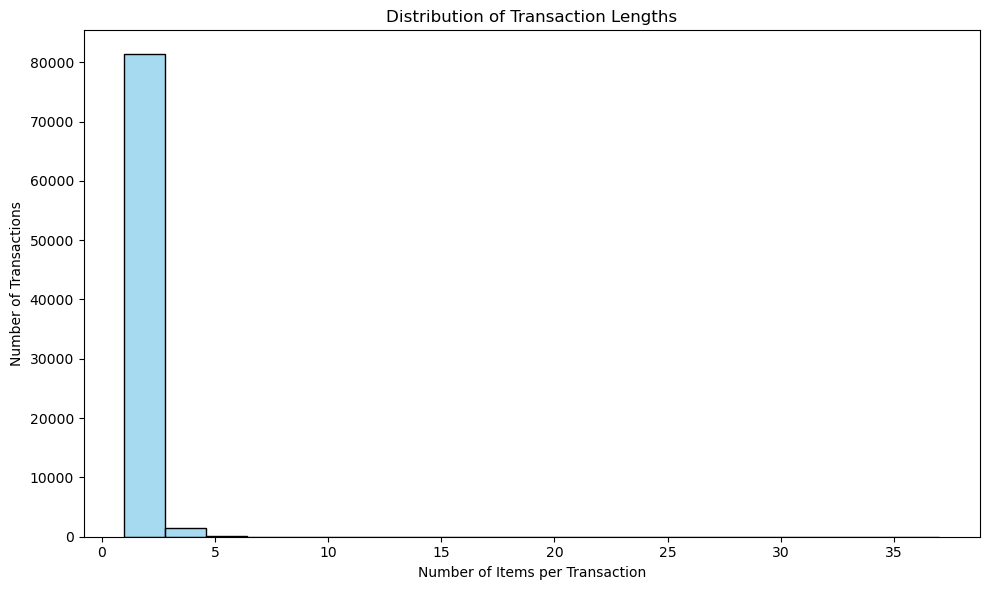

In [18]:
# Plot item frequencies
plt.figure(figsize=(10, 6))
top_items = item_frequency.head(20)
bars = plt.barh(top_items.index, top_items.values, color=plt.cm.viridis(range(len(top_items))))

plt.title('Top 20 Most Frequent Items')
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.tight_layout()
plt.show()

# Plot transaction lengths remains the same
plt.figure(figsize=(10, 6))
sns.histplot(items_per_transaction, bins=20, kde=False, color='skyblue')
plt.title('Distribution of Transaction Lengths')
plt.xlabel('Number of Items per Transaction')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()


# Part 2: Apriori Algorithm Implementation


In [20]:
def apriori(transactions, min_support):
    from collections import defaultdict
    num_transactions = len(transactions)
    min_support_count = min_support * num_transactions

    # Generate 1-itemsets
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[frozenset([item])] += 1

    # Prune items below min_support
    frequent_itemsets = {itemset for itemset, count in item_counts.items() if count >= min_support_count}
    all_frequent_itemsets = {frozenset(itemset): item_counts[itemset] for itemset in frequent_itemsets}
    k = 1

    while frequent_itemsets:
        k += 1
        # Generate candidate itemsets of size k
        candidates = set()
        frequent_itemsets_list = list(frequent_itemsets)
        for i in range(len(frequent_itemsets_list)):
            for j in range(i+1, len(frequent_itemsets_list)):
                itemset1 = frequent_itemsets_list[i]
                itemset2 = frequent_itemsets_list[j]
                union_itemset = itemset1 | itemset2
                if len(union_itemset) == k:
                    candidates.add(union_itemset)

        # Prune candidates with infrequent subsets
        candidates = {itemset for itemset in candidates if all(frozenset(subset) in frequent_itemsets for subset in combinations(itemset, k-1))}

        # Count support for candidates
        candidate_counts = defaultdict(int)
        for transaction in transactions:
            for candidate in candidates:
                if candidate.issubset(transaction):
                    candidate_counts[candidate] += 1

        # Prune candidates below min_support
        frequent_itemsets = {itemset for itemset, count in candidate_counts.items() if count >= min_support_count}

        # Add to all frequent itemsets
        all_frequent_itemsets.update({itemset: count for itemset, count in candidate_counts.items() if count >= min_support_count})

    # Convert counts to support ratios
    all_frequent_itemsets_support = {itemset: count/num_transactions for itemset, count in all_frequent_itemsets.items()}
    return all_frequent_itemsets_support


In [21]:
# Prepare transactions as a list of sets
transactions_list = transactions.tolist()
transactions_list = [set(t) for t in transactions_list]

In [22]:
# Run Apriori algorithm
min_support = 0.01
frequent_itemsets = apriori(transactions_list, min_support)

# Display frequent itemsets and their support values
print(f"\nFrequent Itemsets found by Apriori with min_support = {min_support}:")
for itemset, support in sorted(frequent_itemsets.items(), key=lambda x: -x[1]):
    print(f"Itemset: {set(itemset)}, Support: {support:.4f}")


Frequent Itemsets found by Apriori with min_support = 0.01:
Itemset: {'12V U1 L&amp;G 6'}, Support: 0.0294
Itemset: {'6V GC2 ULTRA GOLF 12'}, Support: 0.0204
Itemset: {'AGM 12V 7AH .187 FASTON'}, Support: 0.0199
Itemset: {'12V 18AH 310CCA AGM 12/0'}, Support: 0.0146
Itemset: {'12V 31DT DURACELL ULTRA AGM 30'}, Support: 0.0135
Itemset: {'AGM 12V 5AH .187 FASTON'}, Support: 0.0130
Itemset: {'DC 12V 35AH J TERM'}, Support: 0.0122
Itemset: {'12V 17.5AH 310 CCA'}, Support: 0.0121
Itemset: {'1.5V IND AA ALK BULK'}, Support: 0.0119
Itemset: {'1.5V ALKAL'}, Support: 0.0118
Itemset: {'12V 30AH 400 CCA'}, Support: 0.0114
Itemset: {'12V U1R L&amp;G 6'}, Support: 0.0112
Itemset: {'1.55V SVROX'}, Support: 0.0112
Itemset: {'12V 27 MARINE DP 12'}, Support: 0.0112
Itemset: {'12V 24 MARINE DP 12'}, Support: 0.0109


- At a minimum support of 0.01, the Apriori algorithm identified 15 frequent itemsets, all of which are single items with support values ranging from approximately 1% to 2.94%. These items represent the most popular battery products in the dataset, indicating high customer demand for these specific models.
- Experiments with different thresholds will be included in the later parts of the notebook.

# Part 3: FP-Growth Algorithm Implementation


In [25]:
class FPTreeNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None

def construct_fp_tree(transactions, min_support_count):
    # First pass: calculate item frequencies
    item_counts = {}
    for transaction in transactions:
        for item in transaction:
            item_counts[item] = item_counts.get(item, 0) + 1
    # Remove infrequent items
    item_counts = {item: count for item, count in item_counts.items() if count >= min_support_count}
    # If no items meet min_support, return None
    if not item_counts:
        return None, None
    # Build header table
    header_table = {item: [count, None] for item, count in item_counts.items()}
    # Second pass: build the tree
    root = FPTreeNode(None, 1, None)
    for transaction in transactions:
        # Remove infrequent items and sort by frequency
        sorted_items = [item for item in transaction if item in item_counts]
        sorted_items.sort(key=lambda item: item_counts[item], reverse=True)
        # Insert into tree
        current_node = root
        for item in sorted_items:
            if item in current_node.children:
                current_node.children[item].count += 1
            else:
                new_node = FPTreeNode(item, 1, current_node)
                current_node.children[item] = new_node
                # Update header table
                if header_table[item][1] is None:
                    header_table[item][1] = new_node
                else:
                    update_header(header_table[item][1], new_node)
            current_node = current_node.children[item]
    return root, header_table

def update_header(node, target_node):
    while node.link is not None:
        node = node.link
    node.link = target_node

def mine_fp_tree(header_table, min_support_count, prefix, frequent_itemsets):
    # Sort header_table items in order of ascending support
    items = [item for item, nodes in sorted(header_table.items(), key=lambda x: x[1][0])]
    for item in items:
        new_prefix = prefix.copy()
        new_prefix.add(item)
        support = header_table[item][0]
        frequent_itemsets[frozenset(new_prefix)] = support
        # Build conditional pattern base
        conditional_patterns = []
        node = header_table[item][1]
        while node is not None:
            path = []
            parent = node.parent
            while parent.item is not None:
                path.append(parent.item)
                parent = parent.parent
            path = path[::-1]
            for _ in range(node.count):
                conditional_patterns.append(path)
            node = node.link
        # Construct conditional FP-tree
        conditional_tree, conditional_header = construct_fp_tree(conditional_patterns, min_support_count)
        if conditional_header is not None:
            # Recursively mine conditional FP-tree
            mine_fp_tree(conditional_header, min_support_count, new_prefix, frequent_itemsets)

def fp_growth(transactions, min_support):
    min_support_count = min_support * len(transactions)
    fp_tree, header_table = construct_fp_tree(transactions, min_support_count)
    frequent_itemsets = {}
    if header_table is not None:
        mine_fp_tree(header_table, min_support_count, set(), frequent_itemsets)
    num_transactions = len(transactions)
    # Convert counts to support ratios
    frequent_itemsets_support = {itemset: support/num_transactions for itemset, support in frequent_itemsets.items()}
    return frequent_itemsets_support

In [26]:
# Run FP-Growth algorithm
min_support = 0.01
frequent_itemsets = fp_growth(transactions_list, min_support)
# Display frequent itemsets and their support values
print(f"\nFrequent Itemsets found by FP-Growth with min_support = {min_support}:")
for itemset, support in sorted(frequent_itemsets.items(), key=lambda x: -x[1]):
    print(f"Itemset: {set(itemset)}, Support: {support:.4f}")


Frequent Itemsets found by FP-Growth with min_support = 0.01:
Itemset: {'12V U1 L&amp;G 6'}, Support: 0.0294
Itemset: {'6V GC2 ULTRA GOLF 12'}, Support: 0.0204
Itemset: {'AGM 12V 7AH .187 FASTON'}, Support: 0.0199
Itemset: {'12V 18AH 310CCA AGM 12/0'}, Support: 0.0146
Itemset: {'12V 31DT DURACELL ULTRA AGM 30'}, Support: 0.0135
Itemset: {'AGM 12V 5AH .187 FASTON'}, Support: 0.0130
Itemset: {'DC 12V 35AH J TERM'}, Support: 0.0122
Itemset: {'12V 17.5AH 310 CCA'}, Support: 0.0121
Itemset: {'1.5V IND AA ALK BULK'}, Support: 0.0119
Itemset: {'1.5V ALKAL'}, Support: 0.0118
Itemset: {'12V 30AH 400 CCA'}, Support: 0.0114
Itemset: {'12V U1R L&amp;G 6'}, Support: 0.0112
Itemset: {'1.55V SVROX'}, Support: 0.0112
Itemset: {'12V 27 MARINE DP 12'}, Support: 0.0112
Itemset: {'12V 24 MARINE DP 12'}, Support: 0.0109


- At a minimum support of 0.01, the FP-Growth algorithm also discovered the same 15 frequent itemsets, highlighting the same high-demand battery products. This consistency confirms the effectiveness of FP-Growth in accurately identifying key items that are frequently purchased by customers, aligning with the results from Apriori.
- Experiments with different thresholds will be included in the later parts of the notebook.

# Part 4: Visualization and Comparison

In [29]:
min_support_values = [0.01, 0.005, 0.003, 0.002, 0.001]
apriori_results = []
fpgrowth_results = []

for min_support in min_support_values:
    min_support_count = min_support * len(transactions_list)
    
    print("\n" + "="*50)
    print(f"\nFrequent Itemsets of size >= 2 found by Apriori with min_support = {min_support}:")
    # Apriori with pruning
    start_time = time.time()
    frequent_itemsets_apriori = apriori(transactions_list, min_support)
    apriori_time = time.time() - start_time
    num_apriori_itemsets = len(frequent_itemsets_apriori)
    apriori_results.append((min_support, num_apriori_itemsets, apriori_time))
    
    for itemset, support in frequent_itemsets_apriori.items():
        if len(itemset) >= 2:
            print(f"Itemset: {set(itemset)}, Support: {support:.4f}")
    
    print("\n" + "="*50)
    print(f"\nFrequent Itemsets of size >= 2 found by FP-Growth with min_support = {min_support}:")
    # FP-Growth
    start_time = time.time()
    frequent_itemsets_fp = fp_growth(transactions_list, min_support)
    fpgrowth_time = time.time() - start_time
    num_fpgrowth_itemsets = len(frequent_itemsets_fp)
    fpgrowth_results.append((min_support, num_fpgrowth_itemsets, fpgrowth_time))
    
    for itemset, support in frequent_itemsets_fp.items():
        if len(itemset) >= 2:
            print(f"Itemset: {set(itemset)}, Support: {support:.4f}")



Frequent Itemsets of size >= 2 found by Apriori with min_support = 0.01:


Frequent Itemsets of size >= 2 found by FP-Growth with min_support = 0.01:


Frequent Itemsets of size >= 2 found by Apriori with min_support = 0.005:
Itemset: {'1.5V IND AAA ALK BULK', '1.5V IND AA ALK BULK'}, Support: 0.0066


Frequent Itemsets of size >= 2 found by FP-Growth with min_support = 0.005:
Itemset: {'1.5V IND AAA ALK BULK', '1.5V IND AA ALK BULK'}, Support: 0.0066


Frequent Itemsets of size >= 2 found by Apriori with min_support = 0.003:
Itemset: {'1.5V IND AAA ALK BULK', '1.5V IND AA ALK BULK'}, Support: 0.0066
Itemset: {'1.5V ALKALINE AA CONTRACTOR 24PK', '1.5V ALKAL'}, Support: 0.0040


Frequent Itemsets of size >= 2 found by FP-Growth with min_support = 0.003:
Itemset: {'1.5V ALKALINE AA CONTRACTOR 24PK', '1.5V ALKAL'}, Support: 0.0040
Itemset: {'1.5V IND AAA ALK BULK', '1.5V IND AA ALK BULK'}, Support: 0.0066


Frequent Itemsets of size >= 2 found by Apriori with min_support = 0.002:
Itemse

**Analysis of the Results:**

At a high minimum support threshold of 0.01, neither Apriori nor FP-Growth algorithms found any frequent itemsets of size 2 or more, indicating that no item pairs were commonly purchased together at this support level. As the minimum support decreases to 0.005, both algorithms identified the itemset `{'1.5V IND AA ALK BULK', '1.5V IND AAA ALK BULK'}` with a support of 0.0066, suggesting these two types of bulk alkaline batteries are often bought together.

When the minimum support is further reduced to 0.003 and 0.002, additional frequent itemsets emerge, including `{'1.5V ALKAL', '1.5V ALKALINE AA CONTRACTOR 24PK'}` and combinations involving `'D ALKALINE BULK'` and `'9V IND ALK BULK'`. This pattern indicates a tendency for customers to purchase multiple types of batteries simultaneously, possibly for varied devices requiring different battery sizes.

At the lowest threshold of 0.001, both algorithms uncovered even more complex itemsets, including triplets like `{'1.5V IND AA ALK BULK', '1.5V IND AAA ALK BULK', 'D ALKALINE BULK'}`. This suggests that as we lower the support threshold, we discover less frequent but meaningful associations where customers purchase a variety of bulk batteries together, reflecting diverse battery needs in single transactions.

## **Results Table**

| **min_support** | **Number of Itemsets** | **Apriori Runtime (s)** | **FP-Growth Runtime (s)** | **Speedup Factor** |
|-----------------|------------------------|-------------------------|---------------------------|--------------------|
| 0.01            | 15                     | 1.0588                  | 0.1283                    | 8.25               |
| 0.005           | 56                     | 15.2081                 | 0.1648                    | 92.21              |
| 0.003           | 88                     | 36.2799                 | 0.1763                    | 205.76             |
| 0.002           | 134                    | 106.1477                | 0.1725                    | 615.50             |
| 0.001           | 237                    | 372.5101                | 0.1920                    | 1,939.36           |

*Note: The speedup factor is calculated as* **Apriori Runtime / FP-Growth**

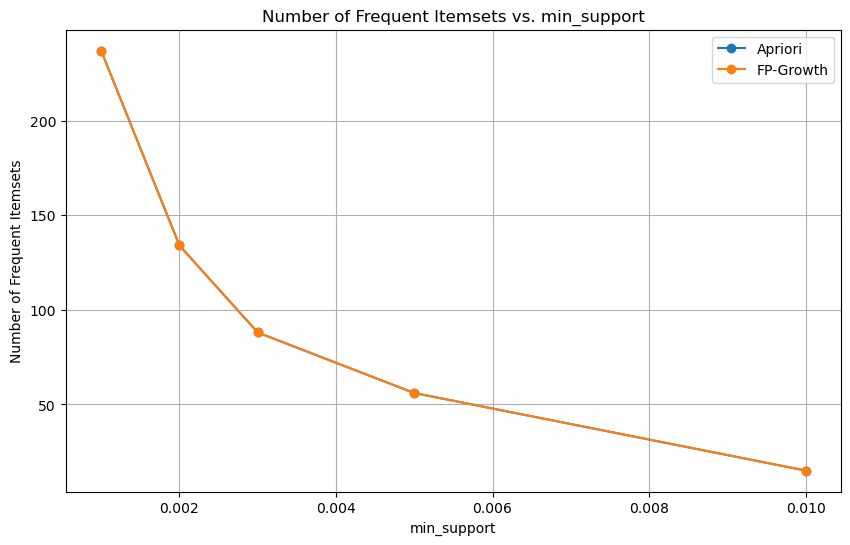

In [32]:
# Prepare data for plotting
apriori_supports = [x[0] for x in apriori_results]
apriori_itemsets = [x[1] for x in apriori_results]
apriori_times = [x[2] for x in apriori_results]

fpgrowth_supports = [x[0] for x in fpgrowth_results]
fpgrowth_itemsets = [x[1] for x in fpgrowth_results]
fpgrowth_times = [x[2] for x in fpgrowth_results]

# Plot Number of Frequent Itemsets vs. min_support
plt.figure(figsize=(10,6))
plt.plot(apriori_supports, apriori_itemsets, marker='o', label='Apriori')
plt.plot(fpgrowth_supports, fpgrowth_itemsets, marker='o', label='FP-Growth')
plt.title('Number of Frequent Itemsets vs. min_support')
plt.xlabel('min_support')
plt.ylabel('Number of Frequent Itemsets')
plt.legend()
plt.grid(True)
plt.show()

- The plots are overlapped because they found the same itemsets.

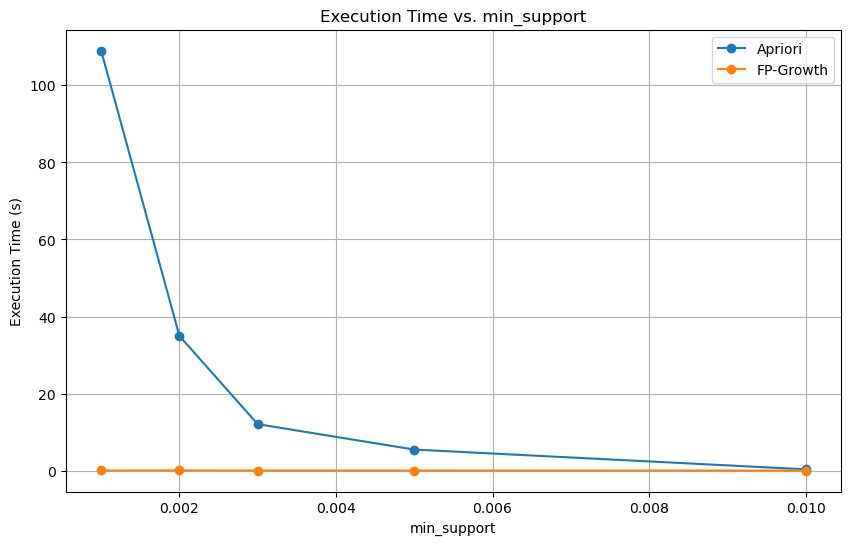

In [34]:
# Plot Execution Time vs. min_support
plt.figure(figsize=(10,6))
plt.plot(apriori_supports, apriori_times, marker='o', label='Apriori')
plt.plot(fpgrowth_supports, fpgrowth_times, marker='o', label='FP-Growth')
plt.title('Execution Time vs. min_support')
plt.xlabel('min_support')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.grid(True)
plt.show()

# **Analysis of Frequent Patterns and Algorithms**

---

## **1. Key Findings and Patterns from the Dataset**

### **Frequent Items at High Support Thresholds**

- **Single High-Demand Products**: At a minimum support of **0.01**, both Apriori and FP-Growth algorithms identified **15 frequent itemsets**, all of which are single items.
  - **Top Products**:
    - `'12V U1 L&G 6'` with a support of **2.94%**
    - `'6V GC2 ULTRA GOLF 12'` with a support of **2.04%**
    - `'AGM 12V 7AH .187 FASTON'` with a support of **1.99%**
  - **Interpretation**: These items are the most popular battery products in the dataset, indicating high customer demand.

### **Emergence of Frequent Item Combinations at Lower Support Thresholds**

- **Itemsets of Size ≥ 2**: As the minimum support threshold decreases, both algorithms begin to identify frequent item combinations.
  - **At 0.005 Support**:
    - **Itemset**: `{'1.5V IND AA ALK BULK', '1.5V IND AAA ALK BULK'}` with a support of **0.66%**
    - **Interpretation**: Customers often purchase bulk AA and AAA industrial alkaline batteries together.
  - **At 0.003 Support**:
    - **Additional Itemset**: `{'1.5V ALKAL', '1.5V ALKALINE AA CONTRACTOR 24PK'}` with a support of **0.40%**
    - **Implication**: There is a purchasing pattern involving AA batteries in contractor packs.
  - **At 0.002 and 0.001 Support**:
    - **More Complex Itemsets**: Combinations involving `'D ALKALINE BULK'`, `'9V IND ALK BULK'`, and triplets like `{'1.5V IND AA ALK BULK', '1.5V IND AAA ALK BULK', 'D ALKALINE BULK'}` emerge.
    - **Interpretation**: Customers purchasing a variety of bulk batteries across different sizes, indicating diverse battery needs in single transactions.

### **Customer Purchasing Behavior Insights**

- **Bulk Purchases of Multiple Battery Types**:
  - **Pattern**: Frequent co-purchase of AA, AAA, D, and 9V batteries in bulk.
  - **Implication**: Customers, possibly businesses or organizations, are stocking up on various battery sizes for extensive use.
- **Cross-Selling Opportunities**:
  - **Observation**: The consistent pairing of certain battery types suggests potential for bundling these items in promotions.

---

## **2. Advantages and Limitations of Both Algorithms**

### **Apriori Algorithm**

- **Advantages**:
  - **Simplicity**: Easy to understand and implement, making it suitable for educational purposes and small datasets.
  - **Well-Established**: Extensive literature and optimization techniques are available.

- **Limitations**:
  - **Computational Intensity**: As the minimum support threshold decreases, the number of candidate itemsets increases exponentially, leading to longer runtimes.
    - **Example**: At a support of 0.001, Apriori uncovers numerous itemsets, including triplets, but with significantly increased computational cost.
  - **Scalability Issues**: Not ideal for large datasets due to the high computational overhead.

### **FP-Growth Algorithm**

- **Advantages**:
  - **Efficiency**: Handles low support thresholds and large datasets more effectively than Apriori.
    - **Performance**: Maintains reasonable runtimes even as the minimum support decreases.
  - **No Candidate Generation**: Uses an FP-tree structure to compress the dataset, reducing the number of database scans.

- **Limitations**:
  - **Complex Implementation**: More challenging to implement and understand due to the recursive nature of the algorithm and the FP-tree structure.
  - **Memory Usage**: Can consume significant memory if the dataset does not have many overlapping transactions to compress.

---

## **3. Frequent Patterns Discovered and Their Potential Implications**

### **Key Frequent Patterns**

- **High-Frequency Single Items**: Certain battery models are consistently popular, indicating stable demand.
- **Frequent Item Combinations**:
  - **Bulk AA and AAA Batteries**: The most prominent itemset of size ≥ 2.
  - **Combination of Battery Sizes**: Customers purchase multiple battery types together, including AA, AAA, D, and 9V.

### **Potential Business Implications**

- **Inventory Management**:
  - **Stock Prioritization**: Ensure high-demand batteries are well-stocked to meet customer needs.
  - **Diverse Inventory**: Maintain a variety of battery sizes in bulk packaging.

- **Marketing Strategies**:
  - **Cross-Promotions**: Bundle commonly purchased batteries together to increase sales.
  - **Targeted Promotions**: Offer discounts on combinations of batteries that are frequently bought together.

- **Customer Relationship Management**:
  - **Understanding Customer Needs**: Recognize that customers may represent businesses requiring various batteries.
  - **Customized Solutions**: Provide tailored packages for bulk buyers, such as contractors or industrial clients.

- **Product Placement**:
  - **Store Layout Optimization**: Place frequently co-purchased items near each other to facilitate convenience shopping.

---

# **Conclusion**

The analysis of the dataset using both Apriori and FP-Growth algorithms reveals significant purchasing patterns centered around bulk battery purchases. As the minimum support threshold decreases, more complex itemsets emerge, highlighting customer tendencies to buy multiple types of batteries simultaneously.

While Apriori is straightforward, it becomes computationally intensive with larger datasets and lower support thresholds. FP-Growth, though more complex, offers superior performance under these conditions. Businesses can leverage these insights to enhance inventory management, optimize marketing strategies, and ultimately meet customer demands more effectively.

---